## From here

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
def paths(fecha, tipoPrueba):
    import glob
    import os
    direc=os.path.join('.','Data',fecha+' '+tipoPrueba,'*.csv')
    path=[]
    for fname in glob.glob(direc):
        path.append(fname)
    return path

In [2]:
def llamarDatos (fecha,tipoPrueba):
    import pandas as pd
    archives=paths(fecha,tipoPrueba)
    dfs={}
    for serie in archives:
        serie_pd = pd.read_csv(serie, sep = ',',encoding='latin-1')
        dfs[serie] = pd.DataFrame(serie_pd)
    return dfs 


In [3]:
def rawDatos(fecha,tipoPrueba,fuerza):
    import pandas as pd
    data=llamarDatos(fecha,tipoPrueba)
    directs=paths(fecha,tipoPrueba)
    df2={}
    rows=[]
    for path in directs:
        data_act=data[path]
        RPM=data_act['Motor Electrical Speed (RPM)']
        Fuerza=data_act[fuerza]
        time=data_act['Time (s)']
        df={'RPM': RPM,fuerza: Fuerza,'time': time}
        df3=pd.DataFrame(df)
        df2[path]=df3.interpolate()#fillna(method='ffill')
        df2[path]=df2[path].fillna(0)
        zero_ind=np.array(df2[path][df2[path]['RPM']<900].index)
        df2[path]=df2[path].drop(zero_ind)
        row=np.shape(df2[path]['RPM'])
        rows.append(row)
    r_min=np.min(rows)
    for path in directs:
        indices=np.array(df2[path]['RPM'][r_min:].index)
        df2[path]=df2[path].drop(indices)
    return df2

In [4]:
def densidad (R,T,P):
    Rm=np.mean(R)/100; Tm=np.mean(T)+273.15; Pm=np.mean(P)*100
    Rd=np.std(R)/100; Td=np.std(T)+273.15; Pd=np.std(P)*100
    esm=(1.7526*10**-11)*np.exp(5315.56/Tm)
    esd=(1.7526*10**-11)*np.exp(5315.56/Td)
    rhom=(0.0034847/Tm)*(Pm-0.003796*Rm*esm)
    rhod=(0.0034847/Tm)*(Pd-0.003796*Rd*esd)
    rhosim=0.877
    err=(rhom-rhosim)*100/rhosim
    return print('rho=%.3f +- %.3g[kg/m^3] con un error del %.3g respecto a la simulación'% (rhom, rhod,err))

In [5]:
def datos(fecha,tipoPrueba,fuerza):
    data=rawDatos(fecha,tipoPrueba,fuerza)
    Ps=paths(fecha,tipoPrueba)
    RPMm=0
    l=len(data[Ps[0]]['RPM'])
    fuerzad=np.zeros((l,len(Ps)))
    for p in Ps:
        i=Ps.index(p)
        RPMm+=data[p]['RPM']
        fuerzad[:,i]=data[p][fuerza]
    RPMm=RPMm/len(Ps)
    RPMs=RPMm; RPMs.iloc[0]=500
    RPMs=RPMm.interpolate()
    return RPMs,fuerzad

In [6]:
def chauvenet (x):
    xm=np.mean(x);xd=np.std(x)
    dev=[abs(i-xm) for i in x]; ts=dev/xd
    probs=2*scipy.stats.norm.cdf(xm-ts*xd,loc=xm, scale=xd)
    for i in probs:
        ind=list(probs).index(i)
        if i<=0.5:
            x[ind]=np.nan
    return x

In [7]:
def dataProm(fecha,tipoPrueba,fuerza):
    RPM=datos(fecha,tipoPrueba,fuerza)[0]
    fuerzas=datos(fecha,tipoPrueba,fuerza)[1]
    mx=np.amax(RPM);#mxi=RPM.index(mx)
    #RPMsout=RPM[mxi:]; indices=RPM.index(RPMsout)
    sh=RPM.shape
    fProm=[]
    for i in range (0,sh[0]):
        fi=chauvenet(fuerzas[i,:])
        f=fi[~np.isnan(fi)].mean()
        fProm.append(f)
    #fProm=np.delete(fProm,indices)
    return RPM,fProm,mx

In [8]:
def filtrados(fecha,tipoPrueba,fuerza,bandwidth):
    data=pd.DataFrame({'RPM':dataProm(fecha,tipoPrueba,fuerza)[0],
                    fuerza:dataProm(fecha,tipoPrueba,fuerza)[1]})
    #bandwidth=100
    steps=np.linspace(500,np.amax(data['RPM']),13)
    indices=[(np.abs(data['RPM']-a).argmin()) for a in steps]
    meanR=[];stdR=[];meanf=[];stdf=[]
    for i in indices:
        j=int(i-bandwidth/2);k=int(i+bandwidth/2)
        mR=np.mean(data['RPM'][j:k])
        dR=np.std(data['RPM'][j:k])
        mf=np.mean(data[fuerza][j:k])
        df=np.std(data[fuerza][j:k])
        meanR=np.append(meanR,mR);stdR=np.append(stdR,dR)
        meanf=np.append(meanf,mf);stdf=np.append(stdf,df)
    return meanR,stdR,meanf,stdf

In [9]:
def plotRaw(fecha,tipoPrueba):
    th='Thrust (N)'
    to='Torque (NÂ·m)'
    #Datos crudos
    dataTh=datos(fecha,tipoPrueba,th)
    dataTo=datos(fecha,tipoPrueba,to)
    Ps=paths(fecha,tipoPrueba)
    l=len(Ps)
    for i in np.arange(l):
        plt.figure(1)
        plt.plot(dataTh[0],dataTh[1][:,i],'^',markersize=1,label=Ps[i])
        plt.legend(loc='lower right', bbox_to_anchor=(1, -0.5))
        plt.xlabel('Velocidad [RPM]');plt.ylabel('Thrust [N]'); plt.title(th)
    for i in np.arange(l):
        plt.figure(2)
        plt.plot(dataTo[0],dataTo[1][:,i],'^',markersize=2,label=Ps[i])
        plt.legend(loc='lower right', bbox_to_anchor=(1, -0.5))
        plt.xlabel('Velocidad [RPM]');plt.ylabel(to);plt.title(to)
    return

In [23]:
def curvaPotencia(fecha,tipoPrueba,bdw):
    w=filtrados(fecha,tipoPrueba,'Torque (NÂ·m)',bdw)[0]
    T=filtrados(fecha,tipoPrueba,'Torque (NÂ·m)',bdw)[2]
    P=T*w
    x=np.log(w);y=np.log(P)
    s=np.polyfit(x,y,1)
    C=np.exp(s[-1]);k=s[-2]
    return w,C*(w**k),C,k

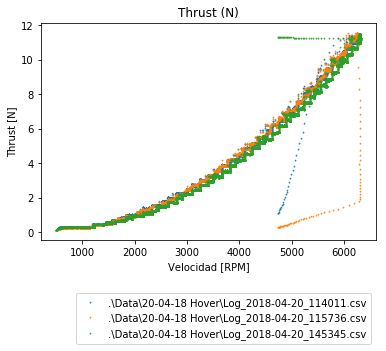

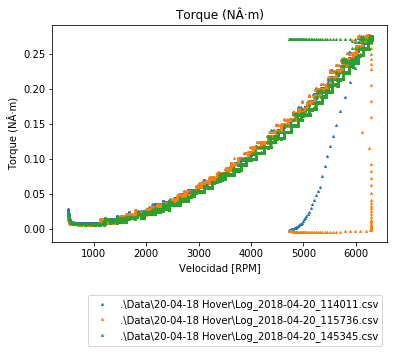

In [24]:
plotRaw('20-04-18','Hover')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6313.333333333333


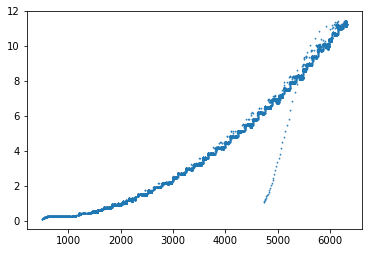

In [25]:
RPM=dataProm('20-04-18','Hover','Thrust (N)')[0]
fl=dataProm('20-04-18','Hover','Thrust (N)')[1]
n=dataProm('20-04-18','Hover','Thrust (N)')[2]
plt.plot(RPM,fl,'^',markersize=1)
print(n)
#print(fl)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


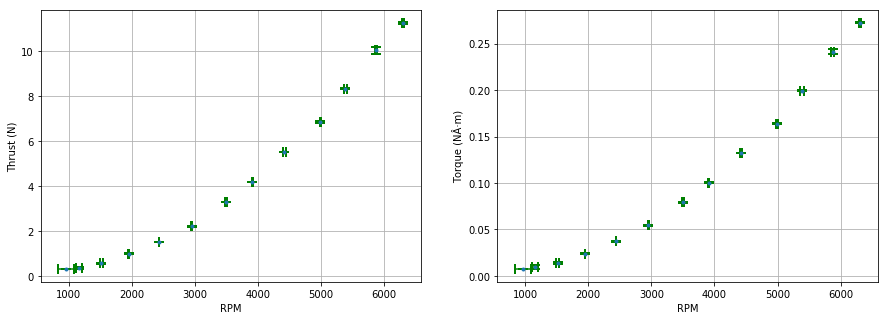

In [26]:
tipo='Hover'
fecha='20-04-18'
th='Thrust (N)'
to='Torque (NÂ·m)'
bdw=200
meanR_th=filtrados(fecha,tipo,th,bdw)[0];stdR_th=filtrados(fecha,tipo,th,bdw)[1]
meanth=filtrados(fecha,tipo,th,bdw)[2];stdth=filtrados(fecha,tipo,th,bdw)[3]

meanR_to=filtrados(fecha,tipo,to,bdw)[0];stdR_to=filtrados(fecha,tipo,to,bdw)[1]
meanto=filtrados(fecha,tipo,to,bdw)[2];stdto=filtrados(fecha,tipo,to,bdw)[3]

fig, axes= plt.subplots(ncols=2,sharex=True,figsize=(15,5))
axes[0].errorbar(meanR_th, meanth, yerr=stdth,xerr=stdR_th,fmt='o',markersize=3, ecolor='g', capsize=5,capthick=2)
axes[0].set_xlabel('RPM');axes[0].set_ylabel(th);axes[0].grid()

axes[1].errorbar(meanR_to, meanto, yerr=stdto,xerr=stdR_to,fmt='o',markersize=3, ecolor='g', capsize=5,capthick=2)
axes[1].set_xlabel('RPM');axes[1].set_ylabel(to);axes[1].grid()


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


P= 7.857e-09 (w^2.980)


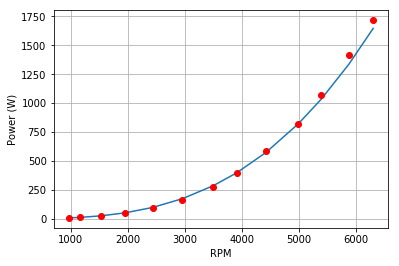

In [33]:
C=curvaPotencia(fecha,tipo,bdw)[2];k=curvaPotencia(fecha,tipo,bdw)[3]
plt.plot(curvaPotencia(fecha,tipo,bdw)[0],curvaPotencia(fecha,tipo,bdw)[1])
plt.plot(meanR_to,meanto*meanR_to,'ro')
plt.xlabel('RPM');plt.ylabel('Power (W)');plt.grid()
D="{:.3e}".format(C)
print('P=',D,'(w^%.3f)'%(k))

In [28]:
R=[68.8,68.7,68.8]; T=[17.6,17.7,18.1]; P=[746.61,746.62,746.62]
densidad(R,T,P)

rho=0.894 +- 5.65e-06[kg/m^3] con un error del 1.96 respecto a la simulación
